In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Clone the Detectron2 repository
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2

# Install dependencies
!pip install -e .


Cloning into 'detectron2'...
remote: Enumerating objects: 15730, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (331/331), done.
remote: Total 15730 (delta 206), reused 299 (delta 113), pack-reused 15277
Receiving objects: 100% (15730/15730), 6.51 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (11321/11321), done.
/kaggle/working/detectron2
Obtaining file:///kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 712.1 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
import os
import json
from pathlib import Path
from PIL import Image

def yolo_to_coco(image_dir, label_dir, output_file, categories):
    images = []
    annotations = []
    annotation_id = 0
    image_id = 0

    for image_file in Path(image_dir).glob("*.jpg"):  # Adjust the image extension if necessary
        image_id += 1
        image = Image.open(image_file)
        width, height = image.size

        images.append({
            "file_name": image_file.name,
            "height": height,
            "width": width,
            "id": image_id
        })

        label_file = label_dir / (image_file.stem + ".txt")
        if label_file.exists():
            with open(label_file, "r") as f:
                for line in f:
                    category_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())
                    x_center *= width
                    y_center *= height
                    bbox_width *= width
                    bbox_height *= height
                    x_min = x_center - bbox_width / 2
                    y_min = y_center - bbox_height / 2

                    annotations.append({
                        "segmentation": [],
                        "area": bbox_width * bbox_height,
                        "iscrowd": 0,
                        "image_id": image_id,
                        "bbox": [x_min, y_min, bbox_width, bbox_height],
                        "category_id": int(category_id),
                        "id": annotation_id,
                    })
                    annotation_id += 1

    coco_format = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": i, "name": name} for i, name in enumerate(categories)]
    }

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    with open(output_file, "w") as f:
        json.dump(coco_format, f, indent=4)

# Example usage
categories = ["class1"]  # Replace with your actual categories
yolo_to_coco(
    image_dir=Path("/kaggle/input/yolovmawa/train1"),
    label_dir=Path("/kaggle/input/yolovmawa/train-output-labels"),
    output_file="annotations/train/annotations.json",
    categories=categories
)
yolo_to_coco(
    image_dir=Path("/kaggle/input/yolovmawa/valid1"),
    label_dir=Path("/kaggle/input/yolovmawa/output-labels"),
    output_file="annotations/val/annotations.json",
    categories=categories
)


In [28]:
import os
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger

# Set up logger
setup_logger()

# Function to unregister a dataset if it's already registered
def unregister_dataset(name):
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

# Register the COCO dataset
train_dataset_name = "my_dataset_train"
val_dataset_name = "my_dataset_val"

unregister_dataset(train_dataset_name)
unregister_dataset(val_dataset_name)

register_coco_instances(train_dataset_name, {}, "annotations/train/annotations.json", "/kaggle/input/yolovmawa/train1")
register_coco_instances(val_dataset_name, {}, "annotations/val/annotations.json", "/kaggle/input/yolovmawa/valid1")

# Set up configuration
cfg = get_cfg()
cfg.merge_from_file("/kaggle/working/detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# Dataset configuration
cfg.DATASETS.TRAIN = (train_dataset_name,)
cfg.DATASETS.TEST = (val_dataset_name,)
cfg.DATALOADER.NUM_WORKERS = 2

# Model configuration
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5000  # Adjust as needed
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Assuming only one class for your dataset

# Output directory
cfg.OUTPUT_DIR = "./output"

# Create the trainer and start training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Save the model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


[06/14 20:55:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/14 20:55:19 d2.utils.events]:  eta: 0:37:23  iter: 19  total_loss: 0.888  loss_cls: 0.6104  loss_box_reg: 0.1961  loss_rpn_cls: 0.07259  loss_rpn_loc: 0.02545    time: 0.4344  last_time: 0.4817  data_time: 0.0218  last_data_time: 0.0062   lr: 4.9953e-06  max_mem: 3125M
[06/14 20:55:28 d2.utils.events]:  eta: 0:38:37  iter: 39  total_loss: 0.8591  loss_cls: 0.5505  loss_box_reg: 0.1916  loss_rpn_cls: 0.03874  loss_rpn_loc: 0.02235    time: 0.4577  last_time: 0.5312  data_time: 0.0083  last_data_time: 0.0065   lr: 9.9902e-06  max_mem: 3125M
[06/14 20:55:37 d2.utils.events]:  eta: 0:38:17  iter: 59  total_loss: 0.7614  loss_cls: 0.4199  loss_box_reg: 0.2286  loss_rpn_cls: 0.04329  loss_rpn_loc: 0.01573    time: 0.4524  last_time: 0.5065  data_time: 0.0126  last_data_time: 0.0153   lr: 1.4985e-05  max_mem: 3125M
[06/14 20:55:46 d2.utils.events]:  eta: 0:37:46  iter: 79  total_loss: 0.6587  loss_cls: 0.3407  loss_box_reg: 0.1889  loss_rpn_cls: 0.05922  loss_rpn_loc: 0.02107    time: 0.4

In [29]:
import os
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.logger import setup_logger

# Set up logger
setup_logger()

# Register the COCO dataset
val_dataset_name = "my_dataset_val"

# Ensure the dataset is registered
if val_dataset_name not in DatasetCatalog.list():
    register_coco_instances(val_dataset_name, {}, "annotations/val/annotations.json", "/kaggle/input/yolovmawa/valid1")

# Set up configuration
cfg = get_cfg()
cfg.merge_from_file("/kaggle/working/detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TEST = (val_dataset_name,)
cfg.MODEL.WEIGHTS = os.path.join("./output", "model_final.pth")  # Load the trained model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Adjust based on your dataset

# Evaluation
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator(val_dataset_name, cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, val_dataset_name)
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Print evaluation results
print(evaluation_results)

# Run predictions on the validation set and visualize some results
import cv2
from detectron2.utils.visualizer import Visualizer

output_dir = "./output/predictions"
os.makedirs(output_dir, exist_ok=True)

for d in DatasetCatalog.get(val_dataset_name):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(val_dataset_name), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_image_path = os.path.join(output_dir, os.path.basename(d["file_name"]))
    cv2.imwrite(result_image_path, out.get_image()[:, :, ::-1])



[06/14 21:32:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [06/14 21:32:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/14 21:32:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 21:32:16 d2.data.datasets.coco]: Loaded 450 images in COCO format from annotations/val/annotations.json
[06/14 21:32:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 21:32:17 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 21:32:17 d2.data.common]: Serializing 450 elements to byte tensors and concatenating them all ...
[06/14 21:32:17 d2.data.common]: Serialized dataset takes 0.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/14 21:32:18 d2.evaluation.evaluator]: Inference done 11/450. Dataloading: 0.0013 s/iter. Inference: 0.0990 s/iter. Eval: 0.0004 s/iter. Total: 0.1007 s/iter. ETA=0:00:44
[06/14 21:32:23 d2.evaluation.evaluator]: Inference done 60/450. Dataloading: 0.0020 s/iter. Inference: 0.0996 s/iter. Eval: 0.0004 s/iter. Total: 0.1021 s/iter. ETA=0:00:39
[06/14 21:32:28 d2.evaluation.evaluator]: Inference done 108/450. Dataloading: 0.0021 s/iter. Inference: 0.1014 s/iter. Eval: 0.0004 s/iter. Total: 0.1040 s/iter. ETA=0:00:35
[06/14 21:32:33 d2.evaluation.evaluator]: Inference done 158/450. Dataloading: 0.0021 s/iter. Inference: 0.1007 s/iter. Eval: 0.0004 s/iter. Total: 0.1033 s/iter. ETA=0:00:30
[06/14 21:32:38 d2.evaluation.evaluator]: Inference done 206/450. Dataloading: 0.0021 s/iter. Inference: 0.1010 s/iter. Eval: 0.0004 s/iter. Total: 0.1035 s/iter. ETA=0:00:25
[06/14 21:32:44 d2.evaluation.evaluator]: Inference done 253/450. Dataloading: 0.0021 s/iter. Inference: 0.1019 s/iter. Eval: 0

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/14 21:33:04 d2.evaluation.evaluator]: Total inference time: 0:00:46.823106 (0.105220 s / iter per device, on 1 devices)
[06/14 21:33:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:45 (0.102372 s / iter per device, on 1 devices)
[06/14 21:33:04 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/14 21:33:04 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/14 21:33:05 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.75s)
creating index...
index created!
[06/14 21:33:05 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[06/14 21:33:05 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[06/14 21:33:05 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[06/14 21:33:05 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP)

In [30]:
import os
import json
from pathlib import Path
from PIL import Image

def yolo_to_coco(image_dir, label_dir, output_file, categories):
    images = []
    annotations = []
    annotation_id = 0
    image_id = 0

    for image_file in Path(image_dir).glob("*.jpg"):  # Adjust the image extension if necessary
        image_id += 1
        image = Image.open(image_file)
        width, height = image.size

        images.append({
            "file_name": image_file.name,
            "height": height,
            "width": width,
            "id": image_id
        })

        label_file = label_dir / (image_file.stem + ".txt")
        if label_file.exists():
            with open(label_file, "r") as f:
                for line in f:
                    category_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())
                    x_center *= width
                    y_center *= height
                    bbox_width *= width
                    bbox_height *= height
                    x_min = x_center - bbox_width / 2
                    y_min = y_center - bbox_height / 2

                    annotations.append({
                        "segmentation": [],
                        "area": bbox_width * bbox_height,
                        "iscrowd": 0,
                        "image_id": image_id,
                        "bbox": [x_min, y_min, bbox_width, bbox_height],
                        "category_id": int(category_id),
                        "id": annotation_id,
                    })
                    annotation_id += 1

    coco_format = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": i, "name": name} for i, name in enumerate(categories)]
    }

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    with open(output_file, "w") as f:
        json.dump(coco_format, f, indent=4)

# Example usage
categories = ["class1"]  # Replace with your actual categories
yolo_to_coco(
    image_dir=Path("/kaggle/input/yolovmawa/test1"),
    label_dir=Path("/kaggle/input/yolovmawa/testpost/output"),
    output_file="annotations/test/annotations.json",
    categories=categories
)


In [31]:
import os
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.logger import setup_logger

# Set up logger
setup_logger()

# Register the COCO dataset
test_dataset_name = "my_dataset_test"

# Ensure the dataset is registered
if test_dataset_name not in DatasetCatalog.list():
    register_coco_instances(test_dataset_name, {}, "annotations/test/annotations.json", "/kaggle/input/yolovmawa/test1")

# Set up configuration
cfg = get_cfg()
cfg.merge_from_file("/kaggle/working/detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TEST = (test_dataset_name,)
cfg.MODEL.WEIGHTS = os.path.join("./output", "model_final.pth")  # Load the trained model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Adjust based on your dataset

# Evaluation
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator(test_dataset_name, cfg, False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, test_dataset_name)
evaluation_results = inference_on_dataset(predictor.model, test_loader, evaluator)

# Print evaluation results
print(evaluation_results)

# Run predictions on the test set and visualize some results
import cv2
from detectron2.utils.visualizer import Visualizer

output_dir = "./output/test_predictions"
os.makedirs(output_dir, exist_ok=True)

for d in DatasetCatalog.get(test_dataset_name):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(test_dataset_name), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_image_path = os.path.join(output_dir, os.path.basename(d["file_name"]))
    cv2.imwrite(result_image_path, out.get_image()[:, :, ::-1])
  


[06/14 21:35:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [06/14 21:35:24 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/14 21:35:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 21:35:24 d2.data.datasets.coco]: Loaded 448 images in COCO format from annotations/test/annotations.json
[06/14 21:35:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 21:35:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 21:35:24 d2.data.common]: Serializing 448 elements to byte tensors and concatenating them all ...
[06/14 21:35:24 d2.data.common]: Serialized dataset takes 0

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/14 21:35:26 d2.evaluation.evaluator]: Inference done 11/448. Dataloading: 0.0014 s/iter. Inference: 0.0921 s/iter. Eval: 0.0004 s/iter. Total: 0.0939 s/iter. ETA=0:00:41
[06/14 21:35:31 d2.evaluation.evaluator]: Inference done 59/448. Dataloading: 0.0021 s/iter. Inference: 0.1011 s/iter. Eval: 0.0004 s/iter. Total: 0.1037 s/iter. ETA=0:00:40
[06/14 21:35:36 d2.evaluation.evaluator]: Inference done 106/448. Dataloading: 0.0021 s/iter. Inference: 0.1031 s/iter. Eval: 0.0004 s/iter. Total: 0.1056 s/iter. ETA=0:00:36
[06/14 21:35:41 d2.evaluation.evaluator]: Inference done 153/448. Dataloading: 0.0021 s/iter. Inference: 0.1037 s/iter. Eval: 0.0004 s/iter. Total: 0.1063 s/iter. ETA=0:00:31
[06/14 21:35:46 d2.evaluation.evaluator]: Inference done 200/448. Dataloading: 0.0021 s/iter. Inference: 0.1041 s/iter. Eval: 0.0004 s/iter. Total: 0.1067 s/iter. ETA=0:00:26
[06/14 21:35:51 d2.evaluation.evaluator]: Inference done 248/448. Dataloading: 0.0021 s/iter. Inference: 0.1039 s/iter. Eval: 0

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/14 21:36:13 d2.evaluation.evaluator]: Total inference time: 0:00:47.313514 (0.106803 s / iter per device, on 1 devices)
[06/14 21:36:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:46 (0.103991 s / iter per device, on 1 devices)
[06/14 21:36:13 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/14 21:36:13 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/14 21:36:13 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[06/14 21:36:13 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[06/14 21:36:13 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[06/14 21:36:13 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[06/14 21:36:13 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP)

[06/14 21:39:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [06/14 21:39:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 21:39:23 d2.data.datasets.coco]: Loaded 448 images in COCO format from annotations/test/annotations.json


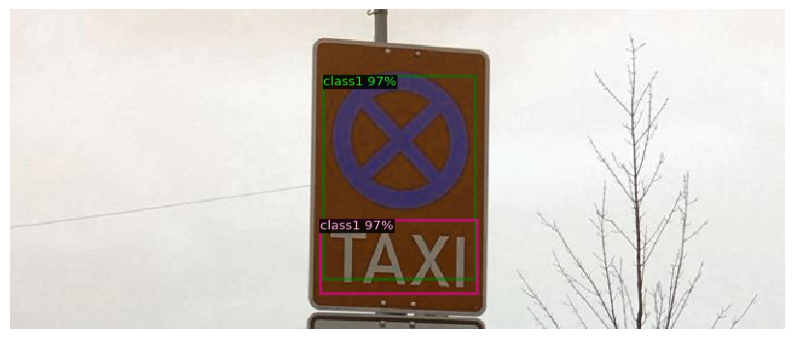

Saved prediction result to ./output/test_predictions/Images-2058-_png.rf.00873d759b4749e009f094144f014a6e.jpg


In [38]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
import matplotlib.pyplot as plt

# Ensure the dataset is registered
test_dataset_name = "my_dataset_test"
if test_dataset_name not in DatasetCatalog.list():
    register_coco_instances(test_dataset_name, {}, "annotations/test/annotations.json", "/kaggle/input/yolovmawa/test1")

# Load the configuration and model
cfg = get_cfg()
cfg.merge_from_file("/kaggle/working/detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = os.path.join("./output", "model_final.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Adjust based on your dataset

# Create the predictor
predictor = DefaultPredictor(cfg)

# Get the test dataset dictionary
dataset_dicts = DatasetCatalog.get(test_dataset_name)

# Select a random image from the test dataset
random_test_image = random.choice(dataset_dicts)
image_path = random_test_image["file_name"]
im = cv2.imread(image_path)

# Run inference on the selected image
outputs = predictor(im)

# Visualize the predictions
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(test_dataset_name), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the result using matplotlib
result_image = out.get_image()[:, :, ::-1]
plt.figure(figsize=(10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.show()

# Save the result to a file
output_dir = "./output/test_predictions"
os.makedirs(output_dir, exist_ok=True)
result_image_path = os.path.join(output_dir, os.path.basename(image_path))
cv2.imwrite(result_image_path, result_image)
print(f"Saved prediction result to {result_image_path}")


In [40]:
import shutil

# Define the path to the model weights
model_weights_path = "./output/model_final.pth"

# Define the path to where you want to save the file locally
local_path = "/kaggle/working/model_final.pth"

# Copy the file to the local path
shutil.copy(model_weights_path, localdd_path)

# Provide a download link
import IPython
IPython.display.FileLink(local_path)


/kaggle/working/model_final.pth